<a href="https://colab.research.google.com/github/JayaBigDataIsCool/Recommender-Systems/blob/master/News_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install PyPDF2

     |████████████████████████████████| 81kB 4.1MB/s 
  Created wheel for PyPDF2: filename=PyPDF2-1.26.0-cp36-none-any.whl size=61086 sha256=d305b7ebe4f026976c8b1e111279711208fbf100f9999417a8f7eecd99ac7787
  Stored in directory: /root/.cache/pip/wheels/53/84/19/35bc977c8bf5f0c23a8a011aa958acd4da4bbd7a229315c1b7
Successfully built PyPDF2


In [40]:
!pip install PyPDF4

In [20]:
import PyPDF2
import os
from os import listdir
from os.path import isfile, join
from io import StringIO
import re
import pandas as pd
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()
from spacy.matcher import PhraseMatcher

In [41]:
mypath='/content/sample_data/Ins/' #enter your path here where you saved the resumes
onlyfiles = [os.path.join(mypath, f) for f in os.listdir(mypath) if os.path.isfile(os.path.join(mypath, f))]

In [42]:
onlyfiles

['/content/sample_data/Ins/Insurance_Handbook_20103.pdf',
 '/content/sample_data/Ins/insurance_factbook_2019.pdf',
 '/content/sample_data/Ins/cfpb_building_block_activities_what-is-insurance_handout.pdf']

In [43]:
def pdfextract(file):
    fileReader = PyPDF2.PdfFileReader(open(file,'rb'))
    countpage = fileReader.getNumPages()
    count = 0
    text = []
    while count < countpage:    
        pageObj = fileReader.getPage(count)
        count +=1
        t = pageObj.extractText()
        #print (t)
        text.append(t)
    return text

In [44]:
#function that does phrase matching and builds a candidate profile
def create_profile(file):
  try:
    text = pdfextract(file)
    text = str(text)
    #text = unicode(text, errors='ignore')
    text = text.replace("\\n", "")
    text = text.lower()
    #print("Text : {}".format(text))
    #below is the csv where we have all the keywords, you can customize your own
    file_encoding = 'cp1252' 
    keyword_dict = pd.read_csv('/content/sample_data/news_recomendation_keywords_v01.csv', encoding=file_encoding)
    ##print("It works till here")
    Auto_words = [nlp(text) for text in keyword_dict['Auto'].dropna(axis = 0)]
    health_words = [nlp(text) for text in keyword_dict['Health'].dropna(axis = 0)]
    life_words = [nlp(text) for text in keyword_dict['Life'].dropna(axis = 0)]
    rntl_words = [nlp(text) for text in keyword_dict['Rental'].dropna(axis = 0)]
    home_words = [nlp(text) for text in keyword_dict['Home'].dropna(axis = 0)]
    ann_words = [nlp(text) for text in keyword_dict['Annutiy'].dropna(axis = 0)]
    trvl_words = [nlp(text) for text in keyword_dict['Travel'].dropna(axis = 0)]

    matcher = PhraseMatcher(nlp.vocab)
    matcher.add('Auto', None, *Auto_words)
    matcher.add('Hlth', None, *health_words)
    matcher.add('LIFE', None, *life_words)
    matcher.add('RNTL', None, *rntl_words)
    matcher.add('HM', None, *home_words)
    matcher.add('ANNU', None, *ann_words)
    matcher.add('TRVL', None, *trvl_words)
    doc = nlp(text)
    
    d = []  
    matches = matcher(doc)
    #print("Matches : {}".format(matches))
    for match_id, start, end in matches:
        rule_id = nlp.vocab.strings[match_id]  # get the unicode ID, i.e. 'COLOR'
        span = doc[start : end]  # get the matched slice of the doc
        d.append((rule_id, span.text))      
    keywords = "\n".join(f'{i[0]} {i[1]} ({j})' for i,j in Counter(d).items())
    
    ## convertimg string of keywords to dataframe
    df = pd.read_csv(StringIO(keywords),names = ['Keywords_List'])
    #print(df)
    df1 = pd.DataFrame(df.Keywords_List.str.split(' ',1).tolist(),columns = ['Subject','Keyword'])
    df2 = pd.DataFrame(df1.Keyword.str.split('(',1).tolist(),columns = ['Keyword', 'Count'])
    df3 = pd.concat([df1['Subject'],df2['Keyword'], df2['Count']], axis =1) 
    df3['Count'] = df3['Count'].apply(lambda x: x.rstrip(")"))
    
    base = os.path.basename(file)
    filename = os.path.splitext(base)[0]
       
    name = filename.split('_')
    name2 = name[0]
    name2 = name2.lower()
    #print(name2)
    ## converting str to dataframe
    name3 = pd.read_csv(StringIO(name2),names = ['Article_Name'])

    
    dataf = pd.concat([name3['Article_Name'], df3['Subject'], df3['Keyword'], df3['Count']], axis = 1)
    dataf['Article_Name'].fillna(dataf['Article_Name'].iloc[0], inplace = True)

    return(dataf)
  except:
    pass

In [45]:
import sys
if sys.version_info[0] >= 3:
    unicode = str

final_database=pd.DataFrame()
i = 0 
while i < len(onlyfiles):
    file = onlyfiles[i]
    dat = create_profile(file)
    final_database = final_database.append(dat)
    i +=1
    #print(final_database)

In [46]:
final_database2 = final_database['Keyword'].groupby([final_database['Article_Name'], final_database['Subject']]).count().unstack()
final_database2.reset_index(inplace = True)
final_database2.fillna(0,inplace=True)
new_data = final_database2.iloc[:,1:]
new_data.index = final_database2['Article_Name']

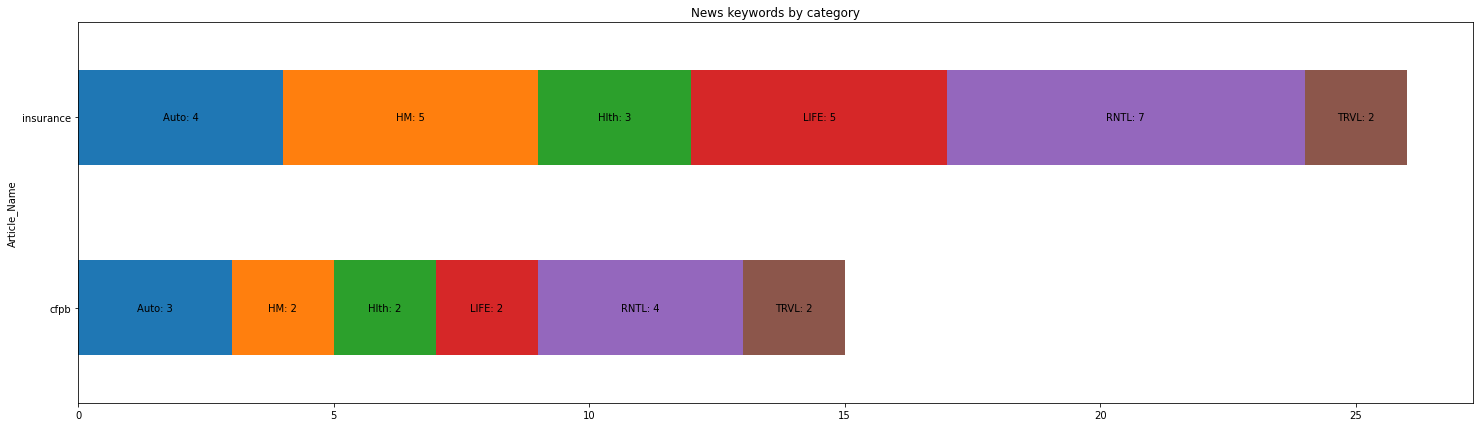

In [47]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10})
ax = new_data.plot.barh(title="News keywords by category", legend=False, figsize=(25,7), stacked=True)
labels = []
for j in new_data.columns:
    for i in new_data.index:
        label = str(j)+": " + str(new_data.loc[i][j])
        labels.append(label)
patches = ax.patches
for label, rect in zip(labels, patches):
    width = rect.get_width()
    if width > 0:
        x = rect.get_x()
        y = rect.get_y()
        height = rect.get_height()
        ax.text(x + width/2., y + height/2., label, ha='center', va='center')
plt.show()